In [27]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
class Value:

  def __init__(self, data, _children=(), _op='', label='') -> None:
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _children = (self, other), _op = '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _children = (self, other), _op = '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "int/float for now"
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad = other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(self.data), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, _children=(self, ), _op='tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out
  
  def backward(self):
    def topo_sort(n):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(n)
      return topo

    self.grad = 1

    for node in reversed(topo_sort(self)):
      node._backward()

In [18]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [225]:
from graphviz import Digraph

def trace(root):

  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR - left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))

    if n.label:
      dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    else:
      dot.node(name=uid, label="{ %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label= n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [19]:
# basic neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neoron
b = Value(6.881373587, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n';

# output
out = n.tanh(); out.label = 'out';
out.backward()

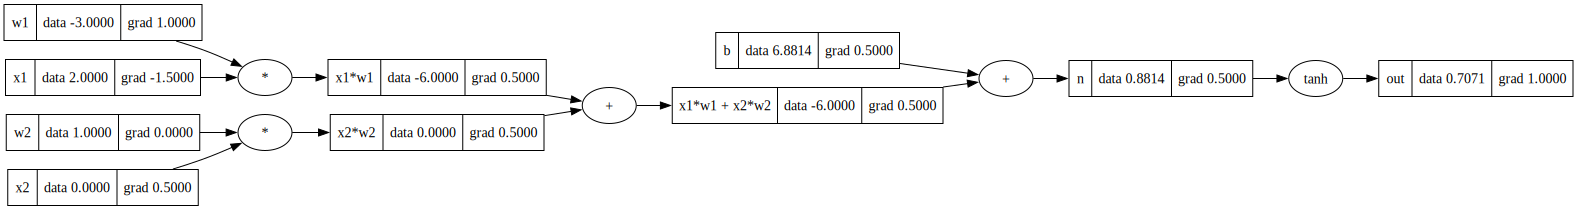

In [20]:
draw_dot(out)

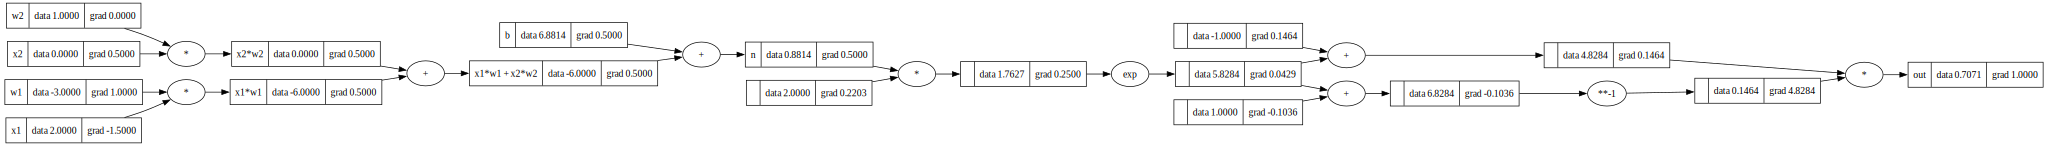

In [22]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neoron
b = Value(6.881373587, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1';
x2w2 = x2*w2; x2w2.label = 'x2*w2';
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2';
n = x1w1x2w2 + b; n.label = 'n';

# ----
e = (2*n).exp()
out = (e - 1) / (e + 1)
# ----
# output
out.label = 'out';
out.backward()

draw_dot(out)

In [26]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373587]).double(); b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('w2', w2.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('x1', x1.grad.item())

x2.grad

0.7071066904050358
w2 0.0
x2 0.5000001283844369
w1 1.0000002567688737
x1 -1.5000003851533106


tensor([0.5000], dtype=torch.float64)

In [228]:
class Neuron:

  def __init__(self, nin) -> None:
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum ((wi*xi for wi, xi in zip(self.w, x)), self.b)
    return act.tanh()
  
  def parameters(self):
    return self.w + [self.b]
  
class Layer:

  def __init__(self, nin, nout) -> None:
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [parameter for neuron in self.neurons for parameter in neuron.parameters()]

# Multi-layer perceptron
class MLP:

  def __init__(self, nin, nouts) -> None:
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [parameter for layer in self.layers for parameter in layer.parameters()]

In [231]:
  
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.2261075613127683)

In [234]:
## NN tuning

# input values
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]   # desired targets
ypred = [n(x) for x in xs]    # predicted targets

ypred

[Value(data=0.2261075613127683),
 Value(data=-0.3379747634019082),
 Value(data=0.6292882189170068),
 Value(data=-0.34456652438222385)]

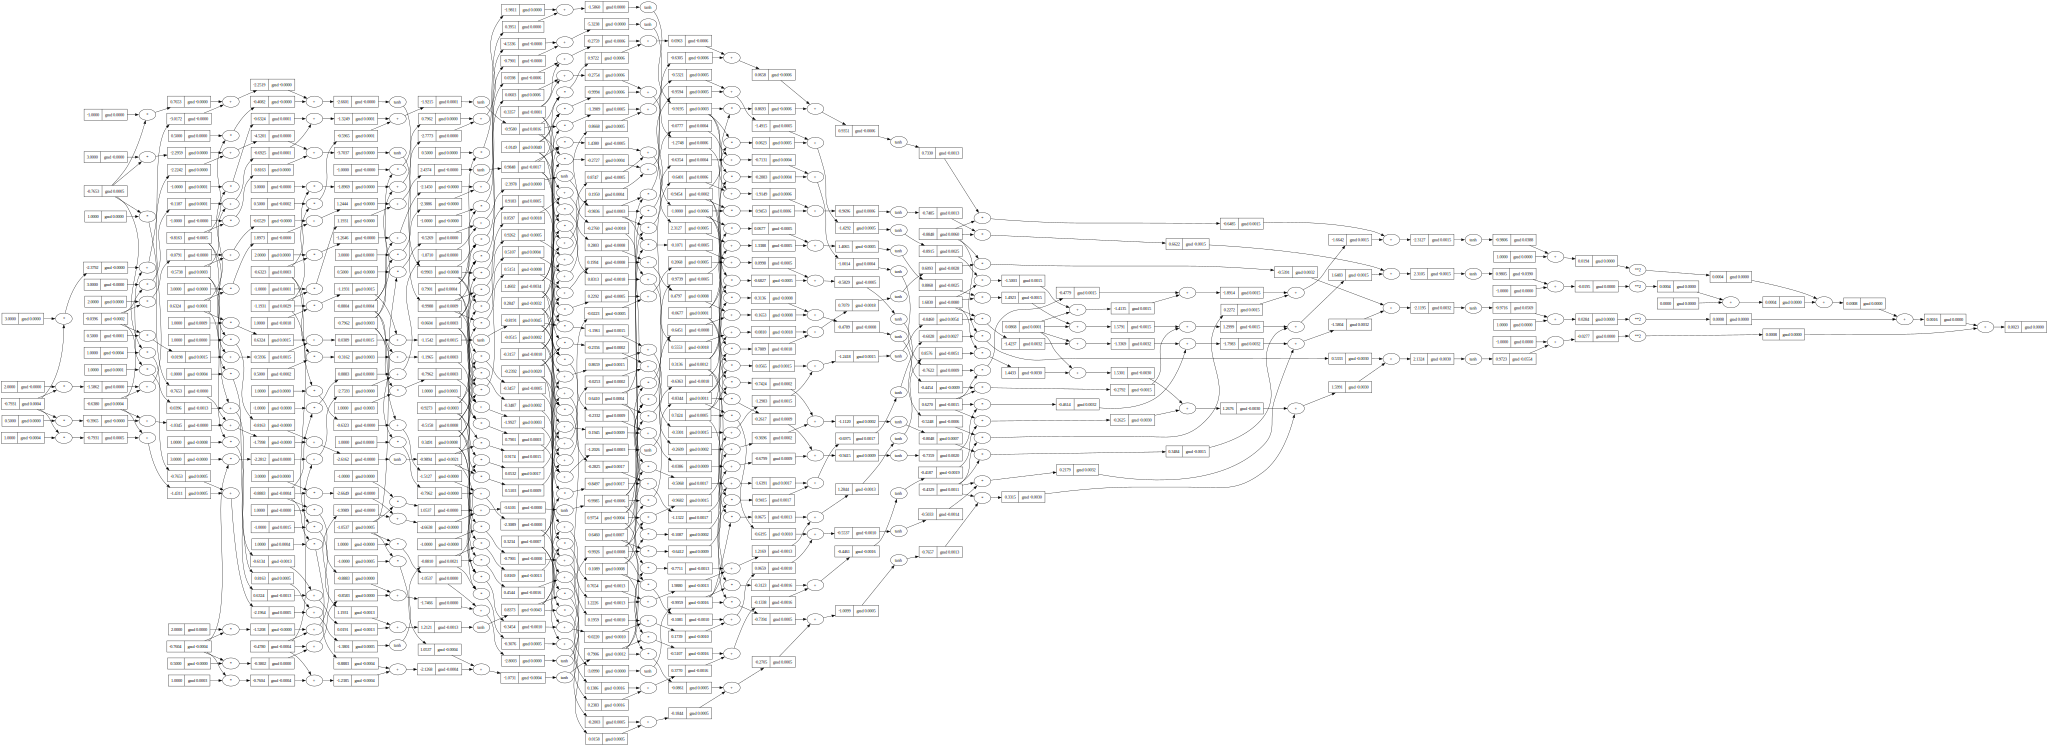

In [1009]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
draw_dot(loss)

In [1005]:
# training
for k in range(10):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update 
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)

0 0.0023646641756164435
1 0.002363005107739462
2 0.002361348260104521
3 0.0023596936283370685
4 0.0023580412080739504
5 0.0023563909949633503
6 0.0023547429846647212
7 0.0023530971728488266
8 0.002351453555197593
9 0.002349812127404185
10 0.002348172885172926
11 0.0023465358242191967
12 0.002344900940269523
13 0.0023432682290614633
14 0.0023416376863435633
15 0.0023400093078753755
16 0.0023383830894273617
17 0.00233675902678091
18 0.0023351371157282657
19 0.0023335173520725437


In [1007]:
[n(x) for x in xs]

[Value(data=0.9805129640052344),
 Value(data=-0.980596443904166),
 Value(data=-0.9715768024337055),
 Value(data=0.9722911744978331)]

In [1008]:
n.parameters()

[Value(data=-0.7930816684834155),
 Value(data=-0.7653102287411905),
 Value(data=-0.8163277682206529),
 Value(data=-0.6380087435271372),
 Value(data=-0.039564760795965534),
 Value(data=0.63243853783827),
 Value(data=-1.1930878074470028),
 Value(data=-0.5737983683345608),
 Value(data=-0.7604084638883932),
 Value(data=-0.8883012680466329),
 Value(data=-1.0537047130380999),
 Value(data=-0.4780444116109007),
 Value(data=-0.6323057476167173),
 Value(data=-0.7962190525596102),
 Value(data=0.7901324048039311),
 Value(data=-0.8803801687573545),
 Value(data=-0.9272903016362094),
 Value(data=1.460199396048071),
 Value(data=0.9753674747962725),
 Value(data=-0.06774459167558948),
 Value(data=-0.05149669809060453),
 Value(data=-0.5157679226304805),
 Value(data=0.28467119852027933),
 Value(data=0.6459887458205771),
 Value(data=0.3135653804197464),
 Value(data=-0.3157277328069975),
 Value(data=0.3491173103290296),
 Value(data=-0.23922298785081222),
 Value(data=0.1088721856571367),
 Value(data=0.742420